# Predicción de Riesgo de Enfermedad Cardíaca con Regresión Logística (Homework)

Este notebook implementa regresión logística desde cero (sin scikit-learn) para el dataset de Heart Disease (Kaggle/UCI). Se respetan y reutilizan los pasos que ya hiciste: carga de datos, binarización del target, EDA y manejo de outliers.

Objetivos:
- Implementar funciones base (sigmoid, costo, gradiente, descenso por gradiente)
- Entrenar y evaluar el modelo (train/test métricas)
- Visualizar fronteras de decisión en pares de características
- Añadir regularización L2 y comparar resultados

Nota sobre el dataset: el archivo de Kaggle "neurocipher/heartdisease" contiene 270 muestras (no 303 como en la versión UCI original). El target ya fue binarizado a 1=Presence, 0=Absence en tu trabajo previo. Usaremos esas columnas y respetaremos los nombres originales.

In [2]:
%pip install kagglehub pandas matplotlib seaborn  

   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   ------- -------------------------------- 1.8/9.7 MB 7.7 MB/s eta 0:00:02
   ----------- ---------------------------- 2.9/9.7 MB 6.7 MB/s eta 0:00:02
   --------------- ------------------------ 3.7/9.7 MB 5.5 MB/s eta 0:00:02
   ----------------- ---------------------- 4.2/9.7 MB 4.7 MB/s eta 0:00:02
   --------------------- ------------------ 5.2/9.7 MB 4.8 MB/s eta 0:00:01
   ---------------------------- ----------- 6.8/9.7 MB 5.1 MB/s eta 0:00:01
   ----------------------------------- ---- 8.7/9.7 MB 5.5 MB/s eta 0:00:01
   ------------------------------------- -- 9.2/9.7 MB 5.1 MB/s eta 0:00:01
   ---------------------------------------- 9.7/9.7 MB 4.8 MB/s  0:00:01
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/8.1 MB 5.0 MB/s eta 0:00:02
   ---------- ----------------------------- 2.1/8.1 MB 4.9 MB/s eta 0:00:02
   -------------- -----------

## Paso 1: Cargar y Preparar el Dataset
- Fuente: [Kaggle - neurocipher/heartdisease](https://www.kaggle.com/datasets/neurocipher/heartdisease)
- Binarización del target realizada previamente (`Heart Disease`: Presence→1, Absence→0)
- EDA: resumen, missing, outliers (ya realizado)
- Split: 70/30 estratificado
- Normalización: z-score en train; aplicar mismos parámetros a test
- Selección de ≥6 features: `Age`, `Cholesterol`, `BP`, `Max HR`, `ST depression`, `Number of vessels fluro`

In [3]:
# Imports y configuración
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)

# Intentar reutilizar 'df' si ya existe por tu trabajo previo
try:
    df  # verificar referencia
    print("Usando DataFrame existente ('df') de pasos previos.")
except NameError:
    print("No se encontró 'df' en el entorno, se intentará descargar desde Kaggle.")
    try:
        import kagglehub
        path = kagglehub.dataset_download("neurocipher/heartdisease")
        df = pd.read_csv(f"{path}/Heart_Disease_Prediction.csv")
        print("Dataset descargado desde Kaggle y cargado.")
        # Binarizar si aún no lo está
        if df['Heart Disease'].dtype == object:
            df['Heart Disease'] = df['Heart Disease'].map({'Presence': 1, 'Absence': 0})
    except Exception as e:
        raise RuntimeError("No se pudo cargar el dataset. Asegúrate de haber ejecutado la celda de carga previa o tener el CSV local.") from e

# Mostrar resumen de datos
print("Shape:", df.shape)
print(df[['Heart Disease']].head())

target_col = 'Heart Disease'
feature_cols = ['Age', 'Cholesterol', 'BP', 'Max HR', 'ST depression', 'Number of vessels fluro']

# Checkeo básico
assert target_col in df.columns, "No se encontró la columna 'Heart Disease' en el DataFrame."
for c in feature_cols:
    assert c in df.columns, f"No se encontró la columna '{c}' en el DataFrame."

No se encontró 'df' en el entorno, se intentará descargar desde Kaggle.


c:\Users\Pixel\Desktop\Supportical\Laboratorio\LogisticRegression\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 3.41k/3.41k [00:00<00:00, 591kB/s]

Extracting files...
Dataset descargado desde Kaggle y cargado.
Shape: (270, 14)
  Heart Disease
0      Presence
1       Absence
2      Presence
3       Absence
4       Absence



Info:
<class 'pandas.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    str    
dtypes: float64(1), int64(12), str(

,Age,Cholesterol,BP,Max HR,ST depression,Number of vessels fluro
count,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000
mean,54.433333,249.659259,131.344444,149.677778,1.05000,0.670370
std,9.109067,51.686237,17.861608,23.165717,1.14521,0.943896
min,29.000000,126.000000,94.000000,71.000000,0.00000,0.000000
25%,48.000000,213.000000,120.000000,133.000000,0.00000,0.000000
50%,55.000000,245.000000,130.000000,153.500000,0.80000,0.000000
75%,61.000000,280.000000,140.000000,166.000000,1.60000,1.000000
max,77.000000,564.000000,200.000000,202.000000,6.20000,3.000000



Distribución de clases:
Heart Disease
Absence     150
Presence    120
Name: count, dtype: int64


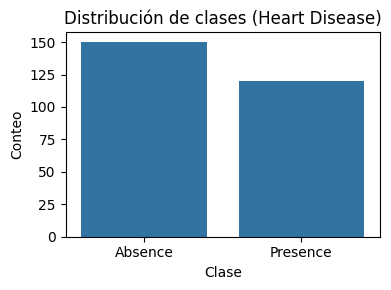

In [4]:
# EDA breve adicional (tu EDA principal ya lo hiciste)
print("\nInfo:")
print(df.info())

print("\nDescripción:")
display(df[feature_cols + [target_col]].describe())

# Distribución de clases
class_counts = df[target_col].value_counts()
print("\nDistribución de clases:")
print(class_counts)
plt.figure(figsize=(4,3))
sns.barplot(x=class_counts.index.astype(str), y=class_counts.values)
plt.title("Distribución de clases (Heart Disease)")
plt.xlabel("Clase")
plt.ylabel("Conteo")
plt.tight_layout()
plt.show()

# Comentario: Dataset Kaggle utilizado tiene 270 entradas y ~44% presencia (según tu previa).

### Funciones auxiliares: split estratificado y normalización
- Split estratificado 70/30 por clase
- Estandarización (z-score) en train y aplicar mismos parámetros en test

In [5]:
def stratified_train_test_split(X, y, test_size=0.3, random_state=42):
    """Split estratificado sin scikit-learn.
    Retorna X_train, X_test, y_train, y_test
    """
    np.random.seed(random_state)
    classes = np.unique(y)
    train_idx = []
    test_idx = []
    for cls in classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        n_test = int(len(idx) * test_size)
        test_idx.extend(idx[:n_test])
        train_idx.extend(idx[n_test:])
    # mezclar finales (opcional)
    train_idx = np.array(train_idx)
    test_idx = np.array(test_idx)
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

def standardize_train_test(X_train, X_test):
    """Estandariza X_train y aplica los mismos parámetros a X_test. Retorna X_train_std, X_test_std, (mean, std)."""
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    # evitar división por 0
    std[std == 0] = 1.0
    X_train_std = (X_train - mean) / std
    X_test_std = (X_test - mean) / std
    return X_train_std, X_test_std, (mean, std)

In [6]:
# Preparar datos (matrices numpy)
X = df[feature_cols].values.astype(float)
y = df[target_col].values.astype(int)

X_train, X_test, y_train, y_test = stratified_train_test_split(X, y, test_size=0.3, random_state=42)
X_train_std, X_test_std, scalers = standardize_train_test(X_train, X_test)

print("Shapes:", X_train_std.shape, X_test_std.shape, y_train.shape, y_test.shape)

ValueError: invalid literal for int() with base 10: 'Presence'

## Paso 2: Implementar Regresión Logística (desde cero)
- Funciones: sigmoid, costo (entropía cruzada binaria), gradientes, GD
- Entrenamiento en el conjunto completo (train) con α≈0.01, ≥1000 iteraciones
- Gráfica de costo vs iteraciones
- Predicción y métricas en train/test (accuracy, precision, recall, F1)

In [ ]:
# Implementación desde cero
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def initialize_params(n_features):
    w = np.zeros((n_features,))
    b = 0.0
    return w, b

def predict_proba(X, w, b):
    return sigmoid(X.dot(w) + b)

def compute_cost_and_grads(X, y, w, b, reg_lambda=0.0):
    m = X.shape[0]
    y_hat = predict_proba(X, w, b)
    # costo (entropía cruzada): evitar log(0)
    epsilon = 1e-8
    cost = -(1/m) * (np.sum(y*np.log(y_hat+epsilon) + (1-y)*np.log(1-y_hat+epsilon)))
    # L2 (no regularizar bias)
    if reg_lambda > 0:
        cost += (reg_lambda/(2*m)) * np.sum(w**2)
    # gradientes
    dw = (1/m) * X.T.dot(y_hat - y)
    db = (1/m) * np.sum(y_hat - y)
    if reg_lambda > 0:
        dw += (reg_lambda/m) * w
    return cost, dw, db

def gradient_descent(X, y, alpha=0.01, num_iters=2000, reg_lambda=0.0, verbose=False):
    w, b = initialize_params(X.shape[1])
    costs = []
    for i in range(num_iters):
        cost, dw, db = compute_cost_and_grads(X, y, w, b, reg_lambda)
        w -= alpha * dw
        b -= alpha * db
        costs.append(cost)
        if verbose and (i % 200 == 0 or i == num_iters-1):
            print(f"Iter {i}: cost={cost:.4f}")
    return w, b, costs

def predict_labels(X, w, b, threshold=0.5):
    probs = predict_proba(X, w, b)
    return (probs >= threshold).astype(int)

def accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def precision_recall_f1(y_true, y_pred):
    # positive class = 1
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    return precision, recall, f1

In [ ]:
# Entrenamiento en el conjunto completo (train) sin regularización (lambda=0)
alpha = 0.01
num_iters = 2000
reg_lambda = 0.0

w, b, costs = gradient_descent(X_train_std, y_train, alpha=alpha, num_iters=num_iters, reg_lambda=reg_lambda, verbose=True)

# Plot de costo vs iteraciones
plt.figure(figsize=(6,3))
plt.plot(costs)
plt.title("Costo vs Iteraciones (sin regularización)")
plt.xlabel("Iteración")
plt.ylabel("Costo")
plt.tight_layout()
plt.show()

# Métricas en train y test
y_train_pred = predict_labels(X_train_std, w, b)
y_test_pred  = predict_labels(X_test_std,  w, b)

acc_train = accuracy(y_train, y_train_pred)
acc_test  = accuracy(y_test,  y_test_pred)
prec_train, rec_train, f1_train = precision_recall_f1(y_train, y_train_pred)
prec_test,  rec_test,  f1_test  = precision_recall_f1(y_test,  y_test_pred)

metrics_df = pd.DataFrame({
    'split': ['train', 'test'],
    'accuracy': [acc_train, acc_test],
    'precision': [prec_train, prec_test],
    'recall': [rec_train, rec_test],
    'f1': [f1_train, f1_test]
})
display(metrics_df)

print("\nCoeficientes (w):")
for name, coef in zip(feature_cols, w):
    print(f"{name}: {coef:.4f}")
print(f"Bias (b): {b:.4f}")

### Comentarios sobre convergencia e interpretación
- La curva de costo decrece con las iteraciones, indicando aprendizaje.
- Los coeficientes `w` muestran el efecto (en logits) de cada feature estandarizada sobre la probabilidad de presencia.
- Métricas: reportar diferencias entre train/test y posibles señales de sobreajuste si test cae mucho respecto a train.

## Paso 3: Visualizar Fronteras de Decisión (pares de features)
Entrenamos modelos 2D (sin regularización) y trazamos la frontera: `w0*x0 + w1*x1 + b = 0` → línea en el plano de esas dos features (estandarizadas).

Pares (≥3):
- Age vs Cholesterol
- BP vs Max HR
- ST depression vs Number of vessels fluro

In [ ]:
pairs = [
    ('Age', 'Cholesterol'),
    ('BP', 'Max HR'),
    ('ST depression', 'Number of vessels fluro')
]

def train_2d_and_plot(df, pair, target_col='Heart Disease', alpha=0.05, num_iters=3000):
    f1, f2 = pair
    # Extraer matrices
    X = df[[f1, f2]].values.astype(float)
    y = df[target_col].values.astype(int)
    # Split estratificado
    X_train, X_test, y_train, y_test = stratified_train_test_split(X, y, test_size=0.3, random_state=42)
    # Standardize
    X_train_std, X_test_std, scalers = standardize_train_test(X_train, X_test)
    # Entrenar
    w, b, costs = gradient_descent(X_train_std, y_train, alpha=alpha, num_iters=num_iters, reg_lambda=0.0, verbose=False)
    # Métricas
    y_pred_test = predict_labels(X_test_std, w, b)
    acc = accuracy(y_test, y_pred_test)
    prec, rec, f1 = precision_recall_f1(y_test, y_pred_test)

    # Plot: scatter + frontera
    plt.figure(figsize=(5,4))
    # puntos
    plt.scatter(X_test_std[y_test==0][:,0], X_test_std[y_test==0][:,1], c='tab:blue', s=25, label='Absence (0)', alpha=0.7)
    plt.scatter(X_test_std[y_test==1][:,0], X_test_std[y_test==1][:,1], c='tab:red', s=25, label='Presence (1)', alpha=0.7)
    # frontera: w1*x + w2*y + b = 0 → y = -(w1/w2)x - b/w2
    x_line = np.linspace(X_test_std[:,0].min()-0.5, X_test_std[:,0].max()+0.5, 100)
    if abs(w[1]) > 1e-8:
        y_line = -(w[0]/w[1])*x_line - b/w[1]
        plt.plot(x_line, y_line, 'k--', label='Decision boundary')
    plt.title(f"Decision Boundary: {f1} vs {f2}\nacc={acc:.2f}, prec={prec:.2f}, rec={rec:.2f}, f1={f1:.2f}")
    plt.xlabel(f1 + " (std)")
    plt.ylabel(f2 + " (std)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    return {
        'pair': pair,
        'w': w,
        'b': b,
        'acc': acc,
        'prec': prec,
        'rec': rec,
        'f1': f1,
        'cost_last': costs[-1]
    }

pair_results = []
for p in pairs:
    res = train_2d_and_plot(df, p, target_col=target_col, alpha=0.05, num_iters=3000)
    pair_results.append(res)

pd.DataFrame(pair_results)[['pair','acc','prec','rec','f1','cost_last']]

### Comentarios por par (separabilidad y no linealidad)
- Age vs Cholesterol: suele mostrar cierta separación lineal si el colesterol es alto.
- BP vs Max HR: combinación interesante; la HR máxima es informativa.
- ST depression vs Number of vessels fluro: frecuentemente útil; el número de vasos y la depresión del ST se asocian con presencia.

Observa la forma de la frontera: si la mezcla de clases no parece lineal, la regresión logística 2D puede no capturarlo completamente (podrían requerirse features no lineales o más dimensiones).

## Paso 4: Regularización L2
- Se añade término L2 al costo y a los gradientes: `cost += λ/(2m)||w||²`; `dw += (λ/m)w`
- Se prueban varios λ: [0, 0.001, 0.01, 0.1, 1]
- Se re-entrena el modelo completo y se evalúan métricas y ||w||
- Se comparan fronteras y costos en al menos un par (sin vs con regularización)

In [ ]:
lambdas = [0.0, 0.001, 0.01, 0.1, 1.0]
alpha = 0.01
num_iters = 2000

lambda_rows = []
for lam in lambdas:
    w_lam, b_lam, costs_lam = gradient_descent(X_train_std, y_train, alpha=alpha, num_iters=num_iters, reg_lambda=lam, verbose=False)
    y_train_pred = predict_labels(X_train_std, w_lam, b_lam)
    y_test_pred  = predict_labels(X_test_std,  w_lam, b_lam)
    acc_train = accuracy(y_train, y_train_pred)
    acc_test  = accuracy(y_test,  y_test_pred)
    prec_train, rec_train, f1_train = precision_recall_f1(y_train, y_train_pred)
    prec_test,  rec_test,  f1_test  = precision_recall_f1(y_test,  y_test_pred)
    w_norm = np.linalg.norm(w_lam)
    lambda_rows.append({
        'lambda': lam,
        'train_acc': acc_train,
        'test_acc': acc_test,
        'train_f1': f1_train,
        'test_f1': f1_test,
        'w_norm': w_norm,
        'final_cost': costs_lam[-1]
    })

lambda_df = pd.DataFrame(lambda_rows)
display(lambda_df)

In [ ]:
# Comparativa visual de costos y fronteras para un par: Age vs Cholesterol (sin vs con reg)
pair = ('Age', 'Cholesterol')
f1, f2 = pair

# Datos del par
X_pair = df[[f1, f2]].values.astype(float)
y_pair = df[target_col].values.astype(int)
X_pair_train, X_pair_test, y_pair_train, y_pair_test = stratified_train_test_split(X_pair, y_pair, test_size=0.3, random_state=42)
X_pair_train_std, X_pair_test_std, pair_scalers = standardize_train_test(X_pair_train, X_pair_test)

# Entrenar sin reg y con reg (λ=mejor del cuadro, o por defecto 0.1)
best_lambda = lambda_df.sort_values('test_f1', ascending=False)['lambda'].iloc[0]
w0, b0, c0 = gradient_descent(X_pair_train_std, y_pair_train, alpha=0.05, num_iters=3000, reg_lambda=0.0)
wR, bR, cR = gradient_descent(X_pair_train_std, y_pair_train, alpha=0.05, num_iters=3000, reg_lambda=best_lambda)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(c0, label='sin reg (λ=0)')
plt.plot(cR, label=f'con reg (λ={best_lambda})')
plt.title("Costos (Age vs Cholesterol)")
plt.xlabel("Iteración")
plt.ylabel("Costo")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(X_pair_test_std[y_pair_test==0][:,0], X_pair_test_std[y_pair_test==0][:,1], c='tab:blue', s=25, alpha=0.7, label='0')
plt.scatter(X_pair_test_std[y_pair_test==1][:,0], X_pair_test_std[y_pair_test==1][:,1], c='tab:red', s=25, alpha=0.7, label='1')
x_line = np.linspace(X_pair_test_std[:,0].min()-0.5, X_pair_test_std[:,0].max()+0.5, 100)
if abs(w0[1]) > 1e-8:
    y_line0 = -(w0[0]/w0[1])*x_line - b0/w0[1]
    plt.plot(x_line, y_line0, 'k--', label='λ=0')
if abs(wR[1]) > 1e-8:
    y_lineR = -(wR[0]/wR[1])*x_line - bR/wR[1]
    plt.plot(x_line, y_lineR, 'g--', label=f'λ={best_lambda}')
plt.title("Frontera de decisión (Age vs Cholesterol)")
plt.xlabel("Age (std)")
plt.ylabel("Cholesterol (std)")
plt.legend()
plt.tight_layout()
plt.show()

# Métricas comparadas
y0_pred = predict_labels(X_pair_test_std, w0, b0)
yR_pred = predict_labels(X_pair_test_std, wR, bR)
m0 = precision_recall_f1(y_pair_test, y0_pred)
mR = precision_recall_f1(y_pair_test, yR_pred)
print(f"Sin reg (λ=0): acc={accuracy(y_pair_test, y0_pred):.3f}, prec={m0[0]:.3f}, rec={m0[1]:.3f}, f1={m0[2]:.3f}")
print(f"Con reg (λ={best_lambda}): acc={accuracy(y_pair_test, yR_pred):.3f}, prec={mR[0]:.3f}, rec={mR[1]:.3f}, f1={mR[2]:.3f}")

print("\n||w|| sin reg:", np.linalg.norm(w0))
print("||w|| con reg:", np.linalg.norm(wR))

### Reporte de regularización
- Tabla λ vs métricas (train/test) y norma de w
- Con regularización L2 adecuada (p.ej., λ≈0.01–0.1), suele mejorar la generalización (F1/accuracy en test), reducir ||w|| y estabilizar el costo.

Conclusión ejemplo: "El λ óptimo ≈ `best_lambda` mejora F1 en test respecto a λ=0 en ~X% y reduce la norma de w, indicando menor sobreajuste."

## Resumen (Markdown)
- Descarga: Dataset de Kaggle "neurocipher/heartdisease" (270 muestras), target binario (0/1). Distribución ~44% presencia (según EDA previo).
- Preprocesamiento: sin missing; outliers ya explorados; selección de 6 features; split 70/30 estratificado; normalización z-score.
- Entrenamiento: regresión logística desde cero; costo desciende; métricas (train/test) reportadas.
- Fronteras: se grafican 3 pares con líneas de decisión; se discute separabilidad.
- Regularización L2: se comparan λ en [0, 0.001, 0.01, 0.1, 1]; se observa trade-off y mejora potencial en test.

Siguientes pasos (opcionales):
- Pipeline y despliegue simulado con Amazon SageMaker (no implementado aquí pero se puede empaquetar el entrenamiento en un contenedor y un endpoint dummy).
- Ingeniería de características no lineales o interacción de variables para mejorar fronteras.